<a href="https://colab.research.google.com/github/jordankando/brillouinfitting/blob/main/6_Burnman3_Elasticity_exercise_corrected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculation of velocity propagation normal to a rotation axis



## Spherical coordinates

(radial, azimuthal, polar), notation ($r$, $\theta$, $\phi$)

![Spherical Coordinates](http://mathworld.wolfram.com/images/eps-gif/SphericalCoordinates_1201.gif)

- For (1 0 0) plane: $\theta=\pi/2$, $\phi$ = from 0 to $\pi/2$

- For (0 0 1) plane: $\phi$ = $\pi/2$, $\theta$ = from 0 to 2$\pi$

# Brillouin Scattering of Single Crystals

It is used to calculate the velocities within a crystallographic plane (hkl).

Refer to the class definition on elastcity calculation in Burnman below:

https://github.com/geodynamics/burnman/blob/master/burnman/classes/anisotropy.py

In [2]:
"""import pip
pip.main(['install','pyquaternion'])"""

"import pip\npip.main(['install','pyquaternion'])"

In [3]:
#!pip install pyquaternion==0.9.9

In [4]:
#!pip install burnman==1.2.0 numpy==1.24.4
#!pip install --force-reinstall numpy==1.24.4
#!pip install orix diffpy.structure



In [5]:
#!pip install numpy==1.25 --quiet --ignore-installed

In [6]:
# import burnman packages, particularly the anisotropy module.
import burnman
from burnman.classes import anisotropy

In [7]:
# first import necessary modules
from __future__ import print_function

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# import the module for matrix rotation

from pyquaternion import Quaternion

In [9]:
# define the styles for the plot
try:
    plt.style.use('ggplot')
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['figure.figsize'] = 16, 10 # inches
except:
    pass

In [10]:
# show the bounds of the moduli and anisotropy

def calc_elastic_properties(mineral):
    """calculate the elasstic properties such as bulk/shear modulus bounds"""

    print('{}\'s elastic properties:\n'.format(mineral.name))
    print('Bulk modulus bounds: {0:.3e} {1:.3e} {2:.3e}'.format(mineral.isentropic_bulk_modulus_reuss,
                                                     mineral.isentropic_bulk_modulus_vrh,
                                                     mineral.isentropic_bulk_modulus_voigt))
    print('Shear modulus bounds: {0:.3e} {1:.3e} {2:.3e}'.format(mineral.isentropic_shear_modulus_reuss,
                                                     mineral.isentropic_shear_modulus_vrh,
                                                     mineral.isentropic_shear_modulus_voigt))
    print('Universal elastic anisotropy: {0:.3f}\n'
          'Isotropic poisson ratio: {1:.3f}'.format(mineral.isentropic_universal_elastic_anisotropy,
                                                    mineral.isentropic_isotropic_poisson_ratio))

In [11]:
# plot the anisotropy polar figure
def plot_anisotropic_seismic_properties(mineral):
    """
    Makes colour plots of:
    Compressional wave velocity: Vp
    Anisotropy: (Vs1 - Vs2)/(Vs1 + Vs2)
    Vp/Vs1
    linear compressibility: beta
    Youngs Modulus: E
    """

    zeniths = np.linspace(np.pi/2., np.pi, 31)
    azimuths = np.linspace(0., 2.*np.pi, 91)
    Rs = np.sin(zeniths)/(1. - np.cos(zeniths))
    r, theta = np.meshgrid(Rs, azimuths)

    vps = np.empty_like(r)
    vs1s = np.empty_like(r)
    vs2s = np.empty_like(r)
    betas = np.empty_like(r)
    Es = np.empty_like(r)
    for i, az in enumerate(azimuths):
        for j, phi in enumerate(zeniths):
            d = np.array([np.cos(az)*np.sin(phi), np.sin(az)*np.sin(phi), -np.cos(phi)]) # change_hemispheres
            velocities = mineral.wave_velocities(d)
            betas[i][j] = mineral.isentropic_linear_compressibility(d)
            Es[i][j] = mineral.isentropic_youngs_modulus(d)
            vps[i][j] = velocities[0][0]
            vs1s[i][j] = velocities[0][1]
            vs2s[i][j] = velocities[0][2]

    fig = plt.figure()
    names = ['Vp (km/s)', 'Vs1 (km/s)', 'Vs2 (km/s)', 'S-wave anisotropy (%)', 'Linear compressibility (GPa$^{-1}$)', 'Youngs Modulus (GPa)']
    items = [vps/1000., vs1s/1000., vs2s/1000., 200.*(vs1s - vs2s)/(vs1s + vs2s), betas*1.e9, Es/1.e9]
    ax = []
    im = []
    ndivs = 100
    for i, item in enumerate(items):
        ax.append(fig.add_subplot(2, 3, i+1, projection='polar'))
        ax[i].set_yticks([100])
        ax[i].set_title(names[i])

        vmin = np.min(item)
        vmax = np.max(item)
        spacing = np.power(10., np.floor(np.log10(vmax - vmin)))
        nt = int((vmax - vmin - vmax%spacing + vmin%spacing)/spacing)
        if nt == 1:
            spacing = spacing/4.
        elif nt < 4:
            spacing = spacing/2.
        elif nt > 8:
            spacing = spacing*2.

        tmin = vmin + (spacing - vmin%spacing)
        tmax = vmax - vmax%spacing
        nt = int((tmax - tmin)/spacing + 1)

        ticks = np.linspace(tmin, tmax, nt)
        im.append(ax[i].contourf(theta, r, item, ndivs, cmap=plt.cm.jet_r, vmin=vmin, vmax=vmax))
        lines = ax[i].contour(theta, r, item, ticks, colors=('black',), linewidths=(1,))

        cbar = fig.colorbar(im[i], ax=ax[i], ticks=ticks)
        cbar.add_lines(lines)

#     plt.tight_layout()
    #plt.savefig("output_figures/example_anisotropy.png")
    plt.show()

In [12]:
from pyquaternion import Quaternion
import numpy as np
np.set_printoptions(suppress=True)

# plot the velocities within a plane (hkl)
def plot_anisotropic_seismic_properties_within_plane(mineral, plane_normal, rotate_angle=180.0, start_vector = []):
    '''
    @param mineral: the defined mineral
    @param plane_normal: the vector perpendicular to the crystallographic plan
    @param rotate_angle: the angle to rotate along the plane normal (default is 180.0 degrees)
    @param start_vector: choose a start vector rotation, default is empty, for which the start_vector will be calculated to be (-k, h, 0)
    '''

    if plane_normal[0] == 0.0 and plane_normal[1] == 0.0:
        direction = [1,0,0]
    else:
        direction = [-plane_normal[1], plane_normal[0], 0]

    if start_vector != []:
        direction = start_vector

    q0 = Quaternion(axis=plane_normal, degrees = 0.0) # rotate 0 about plane normal
    q1 = Quaternion(axis=plane_normal, degrees = rotate_angle) # rotate pi about plane normal

    print("The crystallgraphic plane normal is", plane_normal)

    direction_prime = []
    angle = []

    for q in Quaternion.intermediates(q0, q1, int(rotate_angle) + 1, include_endpoints=True):
        d_prime = q.rotate(direction)
        direction_prime.append(d_prime)
        angle.append(q.degrees)

    vps = np.empty_like(direction_prime)
    vs1s = np.empty_like(direction_prime)
    vs2s = np.empty_like(direction_prime)
    betas = np.empty_like(direction_prime)
    Es = np.empty_like(direction_prime)
    incident_angle = np.empty_like(direction_prime)

    for i, d in enumerate(direction_prime):
        velocities = mineral.wave_velocities(d)
        betas[i] = mineral.isentropic_linear_compressibility(d)
        Es[i] = mineral.isentropic_youngs_modulus(d)
        vps[i] = velocities[0][0]
        vs1s[i] = velocities[0][1]
        vs2s[i] = velocities[0][2]
        incident_angle[i] = angle[i]

    fig = plt.figure()

    names = ['Vp (km/s)', 'Vs1 (km/s)', 'Vs2s', 'S-wave anisotropy (%)', 'Linear compressibility (GPa$^{-1}$)', 'Youngs Modulus (GPa)']
    items = [vps/1000., vs1s/1000., vs2s/1000., 200.*(vs1s - vs2s)/(vs1s + vs2s), betas*1.e9, Es/1.e9]
    ax = []
    im = []
    for i, item in enumerate(items):
        ax.append(fig.add_subplot(2, 3, i+1))
        ax[i].set_title(names[i])

        im.append(ax[i].scatter(incident_angle, item))

    plt.tight_layout()
    plt.show()

# Elastic properties calculations
## Isotropic material
As an example, let's use the lambda (C12), mu (C44) and rho for flow basalt given by **Christensen et al. (1980) Initial Reports of the Deep Sea Drilling Project 59: 515-17.**

IsotropicMaterial's elastic properties:

Bulk modulus bounds: 5.600e+10 5.600e+10 5.600e+10
Shear modulus bounds: 2.400e+10 2.400e+10 2.400e+10
Universal elastic anisotropy: -0.000
Isotropic poisson ratio: 0.312
Linear compressibility along 100: 5.952e-12
Young's modulus along 100: 6.300e+10
Shear modulus on 100 plane in direction 010: 2.400e+10
Poisson ratio for 100/010: 0.31250000000000006
Vp, Vs1, Vs2 (km/s): 5.67, 2.96, 2.96



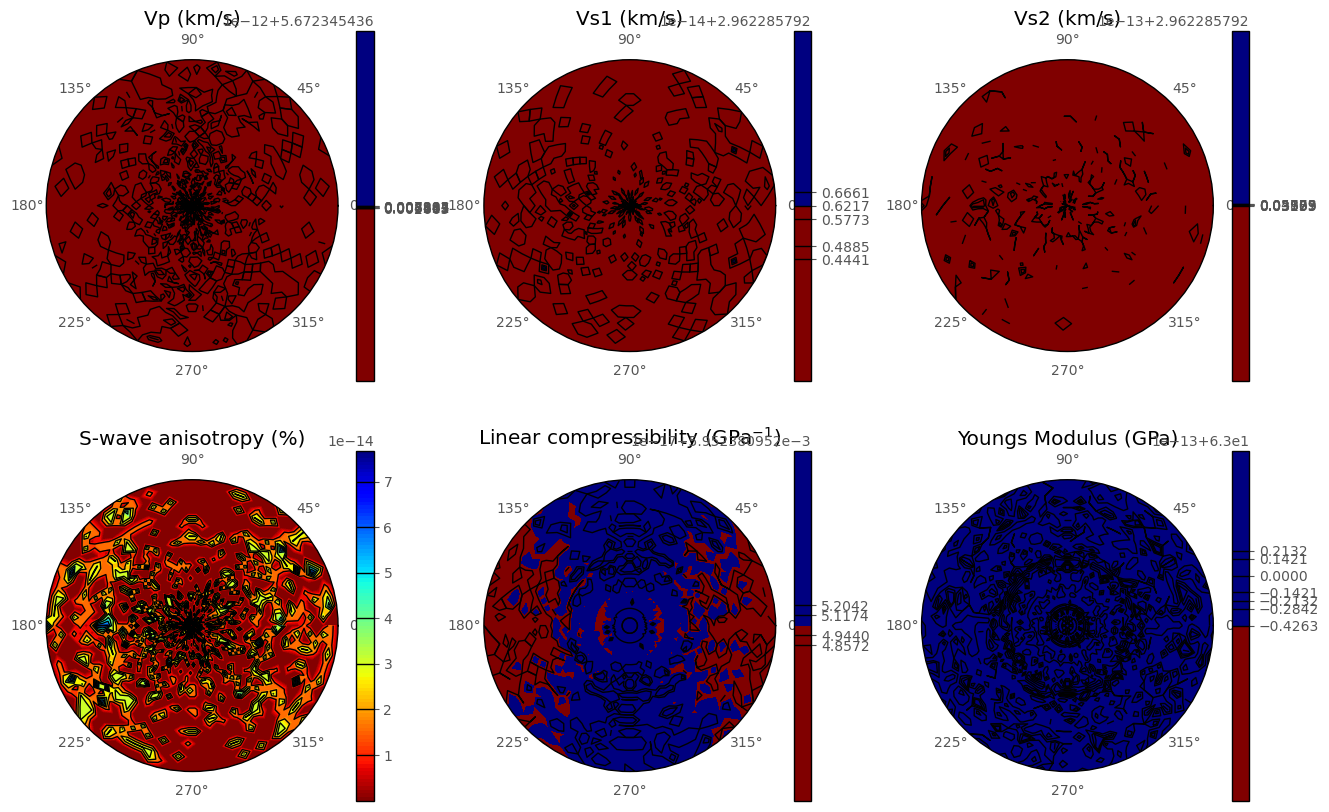

In [13]:
elastic_constants = [0.4e11, 0.24e11] # Cij in Pa
rho = 2.735e3 # kg/m^3
basalt = anisotropy.IsotropicMaterial(rho, elastic_constants)

calc_elastic_properties(basalt)

d1 = [1., 0., 0.]
d2 = [0., 1., 0.]

beta_100 = basalt.isentropic_linear_compressibility(direction=d1)
E_100 = basalt.isentropic_youngs_modulus(direction=d1)
G_100_010 = basalt.isentropic_shear_modulus(plane_normal=d1, shear_direction=d2)
nu_100_010 = basalt.isentropic_poissons_ratio(axial_direction=d1, lateral_direction=d2)
wave_speeds, wave_directions = basalt.wave_velocities(propagation_direction=d1)
Vp, Vs1, Vs2 = wave_speeds

print('Linear compressibility along 100: {0:.3e}\n'
      'Young\'s modulus along 100: {1:.3e}\n'
      'Shear modulus on 100 plane in direction 010: {2:.3e}\n'
      'Poisson ratio for 100/010: {3}\n'
      'Vp, Vs1, Vs2 (km/s): '
      '{4:.2f}, {5:.2f}, {6:.2f}\n'.format(beta_100, E_100,
                                           G_100_010, nu_100_010,
                                           Vp/1.e3, Vs1/1.e3, Vs2/1.e3))
plot_anisotropic_seismic_properties(basalt)

## Anisotropic material.
Here we choose talc, as it is the mineral used as an example in Mainprice et al. (2011)
### Talc

In [14]:
talc_stiffness = [219.83e9,  59.66e9,  -4.82e9,  -0.82e9, -33.87e9, -1.04e9,
                  216.38e9, -3.67e9,   1.79e9, -16.51e9,  -0.62e9,
                  48.89e9,    4.12e9, -15.52e9,  -3.59e9,
                  26.54e9,    -3.6e9,  -6.41e9,
                  22.85e9,   -1.67e9,
                  78.29e9] # Cij in Pa
rho = 2.75e3 # kg/m^3
talc = anisotropy.TriclinicMaterial(rho, talc_stiffness)

print('Talc elastic properties:\n')
print('Bulk modulus bounds: {0:.3e} {1:.3e} {2:.3e}'.format(talc.isentropic_bulk_modulus_reuss,
                                                 talc.isentropic_bulk_modulus_vrh,
                                                 talc.isentropic_bulk_modulus_voigt))
print('Shear modulus bounds: {0:.3e} {1:.3e} {2:.3e}'.format(talc.isentropic_shear_modulus_reuss,
                                                 talc.isentropic_shear_modulus_vrh,
                                                 talc.isentropic_shear_modulus_voigt))
print('Universal elastic anisotropy: {0:.3f}\n'
      'Isotropic poisson ratio: {1:.3f}'.format(talc.isentropic_universal_elastic_anisotropy,
                                                talc.isentropic_isotropic_poisson_ratio))

Talc elastic properties:

Bulk modulus bounds: 1.889e+10 4.208e+10 6.527e+10
Shear modulus bounds: 2.642e+10 4.044e+10 5.446e+10
Universal elastic anisotropy: 7.763
Isotropic poisson ratio: 0.136


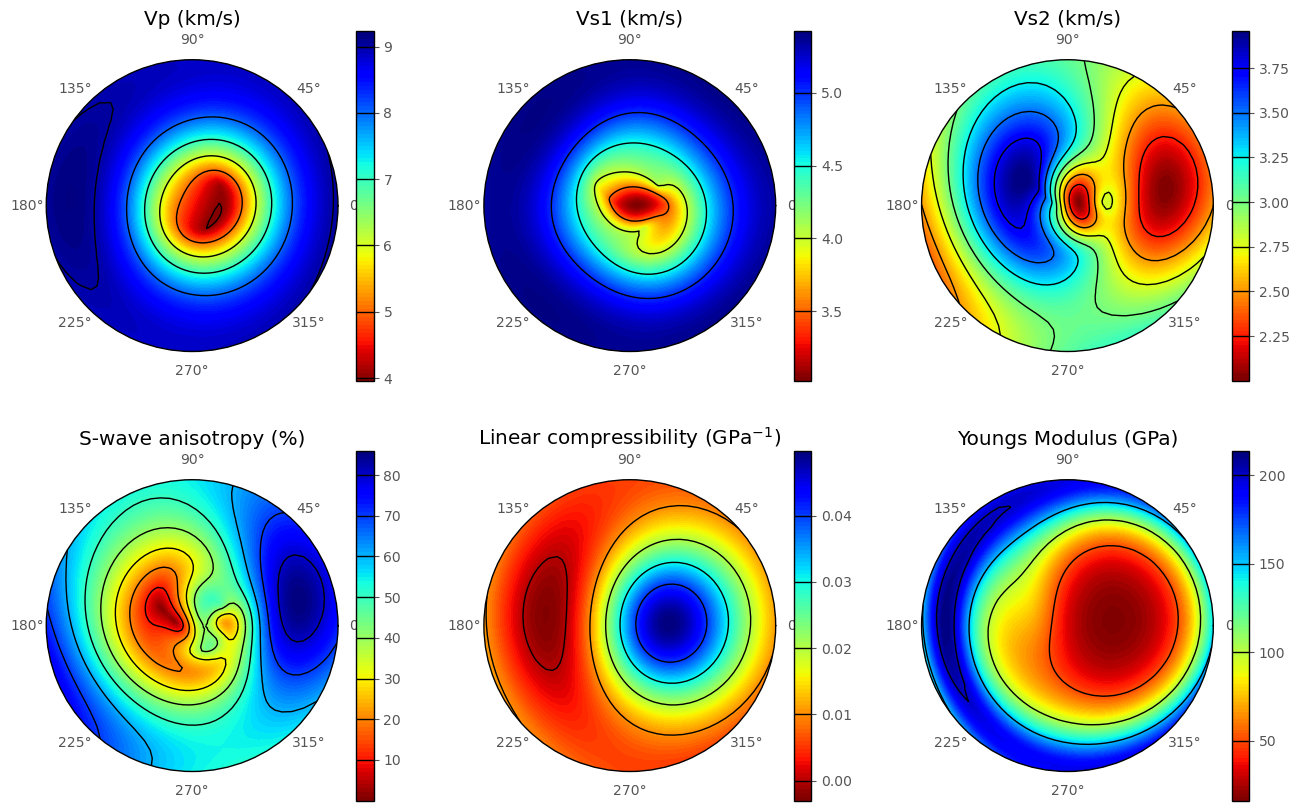

In [15]:
plot_anisotropic_seismic_properties(talc)

The crystallgraphic plane normal is [1, 1, 1]


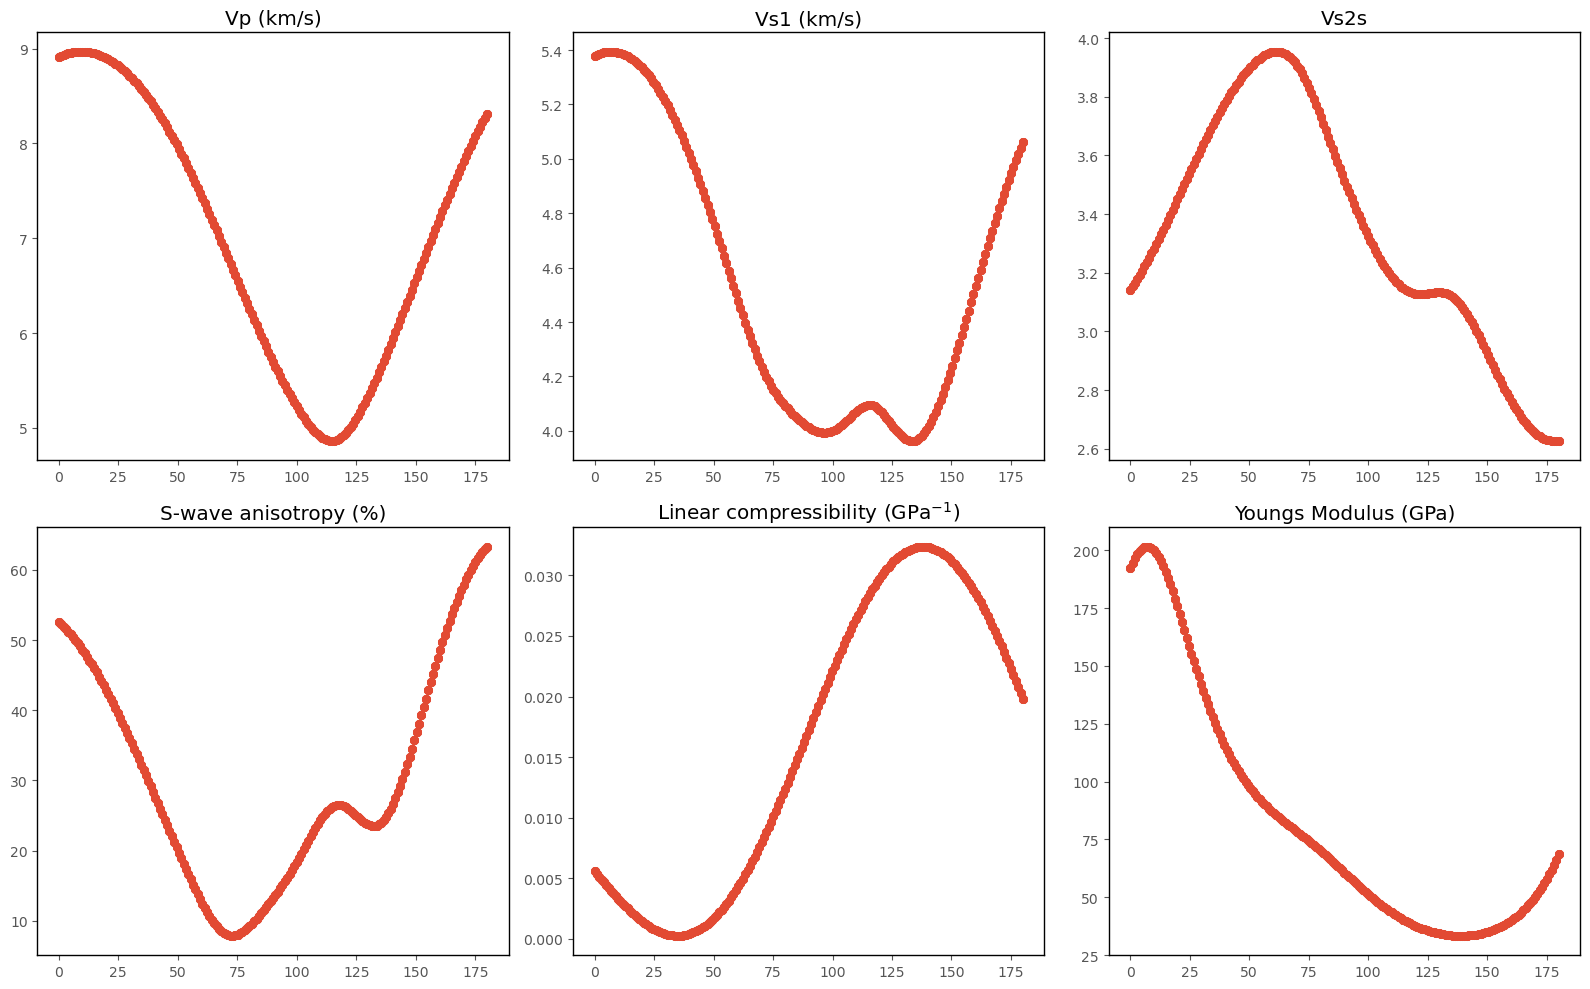

In [16]:
plot_anisotropic_seismic_properties_within_plane(talc, [1,1,1], start_vector=[-0.5,1,0])

## Stishovite

Stishovite's elastic properties:

Bulk modulus bounds: 3.011e+11 3.082e+11 3.153e+11
Shear modulus bounds: 2.161e+11 2.281e+11 2.400e+11
Universal elastic anisotropy: 0.600
Isotropic poisson ratio: 0.203


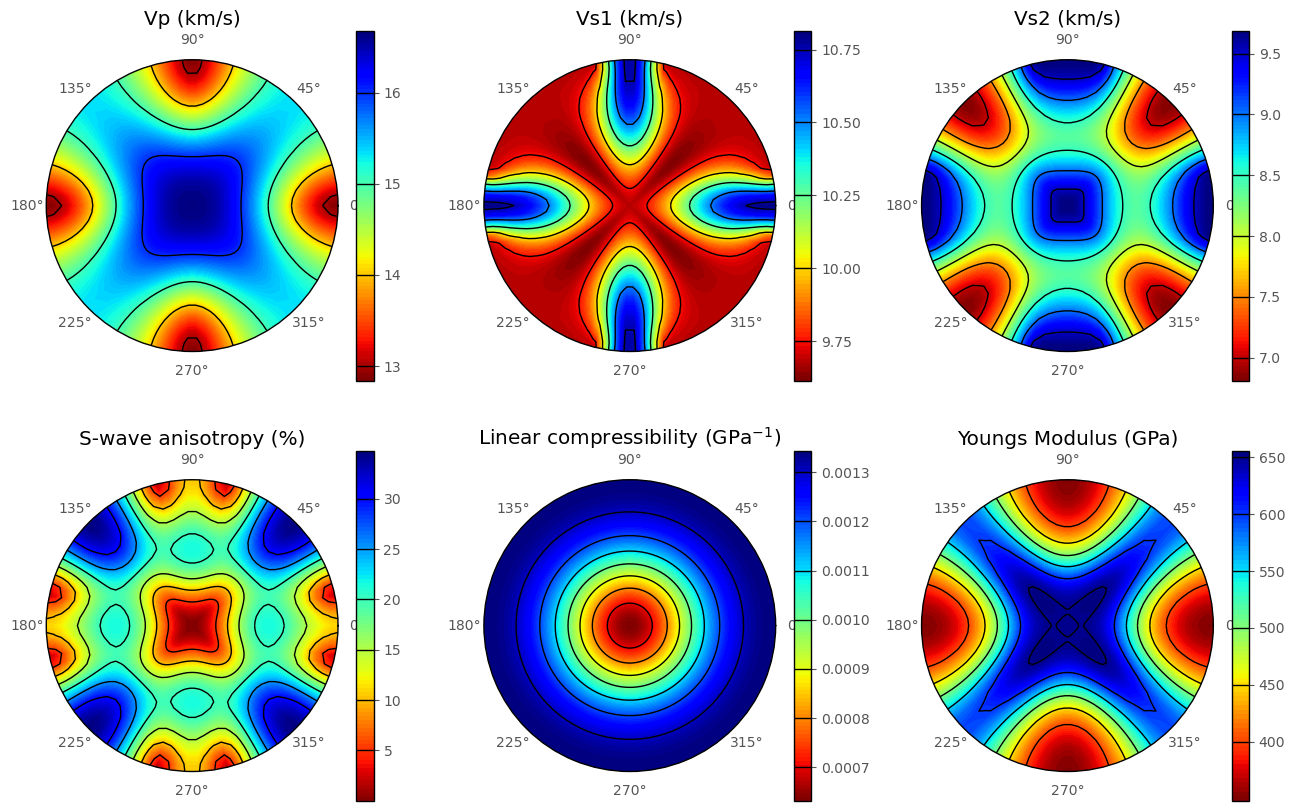

In [17]:
# Now let's look at the properties of an anisotropic material.
# Here we choose talc, as it is the mineral used as an example
# in Mainprice et al. (2011)
stishovite_stiffness = [455e9,  199e9,  192e9,  762e9, 258e9, 321e9]
rho = 2.75e3
stishovite = anisotropy.TetragonalMaterial(rho, stishovite_stiffness)
stishovite.name = "Stishovite"

calc_elastic_properties(stishovite)
plot_anisotropic_seismic_properties(stishovite)


The crystallgraphic plane normal is [1, 1, 0]


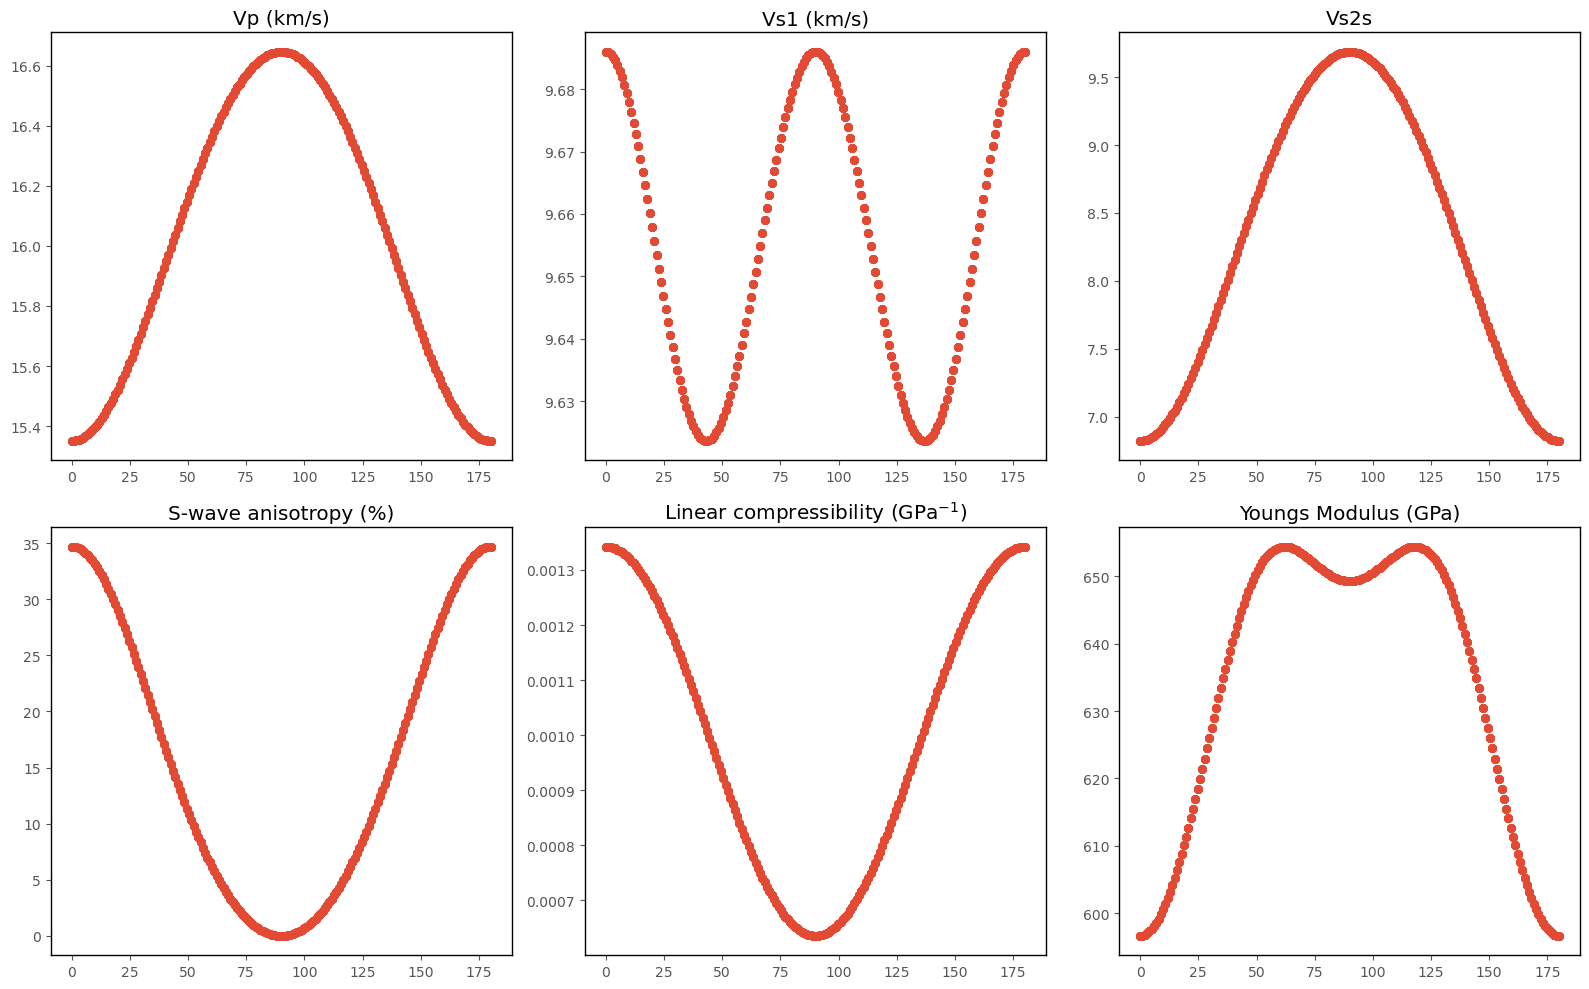

In [18]:
plot_anisotropic_seismic_properties_within_plane(stishovite, [1,1,0], start_vector = [-1, 1, 0])

# Project  Portion:


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np


import burnman.utils.unitcell
import scipy.optimize


See https://orix.readthedocs.io/en/stable/tutorials/crystal_reference_frame.html for reference for below calculation.


In [20]:
# TODO: Convert Miller indices to cartesian vector, and vice versa
# recall Miller Index to Cartesian Coordinate is equal to the inversion of the
# (h k l) = (1/x , 1/y, 1/z) ; (1 0 0) is (1, inf, inf); (2 1 0) is (1/2, 1, inf)
def convert_miller_to_cartesian(hkl, unit_cell_params):
  A = burnman.utils.unitcell.cell_parameters_to_vectors(unit_cell_params)
  xyz = hkl @ np.linalg.inv(A).T
  return xyz

def convert_cartesian_to_miller(xyz, unit_cell_params):
  [a, b, c, alpha, beta, gamma] = unit_cell_params
  A = burnman.utils.unitcell.cell_parameters_to_vectors(unit_cell_params)

  hkl = xyz @ np.linalg.inv(np.linalg.inv(A).T)
  return hkl



In [21]:
def compute_anisotropic_params(mineral,
                              angle_range,
                              angle_count,
                              plane_normal,
                              direction,
                              offset = 0):

  direction_prime = []
  angle = []

  angles = np.linspace(offset, offset+angle_range, angle_count)

  direction_prime = []
  angle = []

  for a in angles:
    q = Quaternion(axis = plane_normal, degrees = a)
    d_prime = q.rotate(direction)
    direction_prime.append(d_prime)
    angle.append(q.degrees)

  vps = []
  vs1s = []
  vs2s = []
  betas = []
  Es = []
  #incident_angle = np.empty_like(direction_prime)

  for i, d in enumerate(direction_prime):
      velocities = mineral.wave_velocities(d)
      betas.append(mineral.isentropic_linear_compressibility(d))
      Es.append(mineral.isentropic_youngs_modulus(d))
      vps.append(velocities[0][0])
      vs1s.append(velocities[0][1])
      vs2s.append(velocities[0][2])

  return (vps, vs1s, vs2s, betas, Es)

In [22]:
# Same as above, but velocities only
def compute_anisotropic_vel(mineral,
                            angle_range,
                            angle_count,
                            plane_normal,
                            direction,
                            offset = 0):

  angles = np.linspace(offset, offset+angle_range, angle_count)

  direction_prime = []
  angle = []

  for a in angles:
    q = Quaternion(axis = plane_normal, degrees = a)
    d_prime = q.rotate(direction)
    direction_prime.append(d_prime)
    angle.append(q.degrees)

  vps = []
  vs1s = []
  vs2s = []
  betas = []
  Es = []
  #incident_angle = np.empty_like(direction_prime)

  for i, d in enumerate(direction_prime):
      velocities = mineral.wave_velocities(d)
      vps.append(velocities[0][0])
      vs1s.append(velocities[0][1])
      vs2s.append(velocities[0][2])

  return (vps, vs1s, vs2s)

In [111]:
def fit_Cij_lsq(xs,
            ys,
            theta_0,
            mineral_type,
            rho,
            hkl_norm,
            unit_cell_params):

  """Primary fitting function:

  Args:

  xs: (1xn) Measurement angles in degrees (nd.array)
  ys: (3xn) M output parameters (vp, vs1, vs2)  (nd.array):
  theta0: Initial guesses on Cijs, offset angle
  mineral_type: Mineral defining function from burnman (default: burnman.anisotropy.CubicMaterial)
  rho: density in units?
  hkl_norm: Miller indices of plane normal
  unit_cell_params: a, b, c, alpha, beta, gamma that define a particular unit cell
  """

  ys_flat = np.array(ys)
  ys_flat = ys.flatten()

  # Convert plane hkl to Cartesian vector of plane normal
  plane_normal = convert_miller_to_cartesian(hkl=hkl_norm,
                                             unit_cell_params = unit_cell_params)

  # Determine starting vector orthogonal to plane normal

  # Handle edge case where if starting vector is [0,0,1],
  # then would return [0,0,0] as vector
  if plane_normal[0] == 0.0 and plane_normal[1] == 0.0:
        direction = [1,0,0]
  else:
        direction = np.array([-plane_normal[1], plane_normal[0], 0])
        direction = direction / np.linalg.norm(direction) # Normalize dir vector

  #Determine angle range to compute over
  angle_range = np.max(xs) - np.min(xs)
  angle_count = xs.size

  #Define objective function for least squares optimization
  def obj_fun(params,
               ys = ys_flat,
               mineral_type = mineral_type,
               angle_range = angle_range,
               angle_count = angle_count,
               direction = direction,
               plane_normal = plane_normal):

    #All non-offset parameters are some number of Cij
    offset = params[-1]
    Cijs = params[:-1]

    #Define mineral using burnman.anisotropy mineral class for given Cijs
    mineral = mineral_type(rho, Cijs)

    #Compute anisotropic parameters
    (vps, vs1s, vs2s) = compute_anisotropic_vel(mineral = mineral,
                                                angle_range = angle_range,
                                                angle_count = angle_count, #due to included endpoints
                                                plane_normal = plane_normal,
                                                direction = direction,
                                                offset = offset)
    #Consolidate multiple properties of material
    ymodel = np.array(vps + vs1s + vs2s)

    #Return differnce between modeled and observed properties
    return ymodel - ys

  # No bounds on Cij
  low_bound = np.ones_like(theta_0[:-1]) * -np.inf
  high_bound = -low_bound

  # Offset bound between -180 and 180 deg for symmetry
  low_bound = low_bound.tolist() + [-180.]
  high_bound = high_bound.tolist() + [180.]


  # Use sci-py to perform simple non-linear least squares fitting
  result = scipy.optimize.least_squares(fun = obj_fun,
                                          x0 = theta_0,
                                          bounds = (low_bound, high_bound),
                                          verbose = 1,
                                          max_nfev=1e15,
                                          ftol = 1e-15)

  print(result.x)

  # Compute full curve for best fit model
  min_model = mineral_type(rho, result.x[:-1])
  best_fit_model = compute_anisotropic_vel(mineral = min_model,
                                          angle_range = 360,
                                          angle_count = 360,
                                          plane_normal = plane_normal,
                                          direction = direction,
                                          offset = result.x[-1])

  plt.figure()

  return result.x


In [24]:
convert_miller_to_cartesian([1,0,0], [1,2,1,90,90,120])

array([ 1.        ,  0.57735027, -0.        ])

In [25]:
# TODO: Generate sparse test data for testing the fitting

def generate_sparse_test_data(mineral_type, Cijs, offset, start_angle, end_angle, hkl_norm, rho, unit_cell_params, n_data = 15, noise_mean = 1, noise_sigma = 0.1):

  mineral = mineral_type(rho, Cijs)

  #print(dir(mineral))


  angle_range = -(start_angle - end_angle)

  plane_normal = convert_miller_to_cartesian(hkl=hkl_norm,
                                             unit_cell_params = unit_cell_params)

  angles = np.linspace(start_angle, end_angle, n_data)

  # Handle edge case where if starting vector is [0,0,1],
  # then would return [0,0,0] as vector
  if plane_normal[0] == 0.0 and plane_normal[1] == 0.0:
        direction = [1,0,0]
  else:
        direction = np.array([-plane_normal[1], plane_normal[0], 0])
        direction = direction / np.linalg.norm(direction) # Normalize dir vector

  #Compute anisotropic parameters
  (vps, vs1s, vs2s) = compute_anisotropic_vel(mineral = mineral,
                                              angle_range = angle_range,
                                              angle_count = n_data, #due to included endpoints
                                              plane_normal = plane_normal,
                                              direction = direction,
                                              offset = offset)

  vps = np.array(vps)
  vs1s = np.array(vs1s)
  vs2s = np.array(vs2s)

  #print(np.random.normal(noise_mean, noise_sigma))

  vps += np.random.normal(noise_mean, noise_sigma, len(vps))
  vs1s += np.random.normal(noise_mean, noise_sigma,len(vps))
  vs2s += np.random.normal(noise_mean, noise_sigma,len(vps))

  return angles, vps, vs1s, vs2s

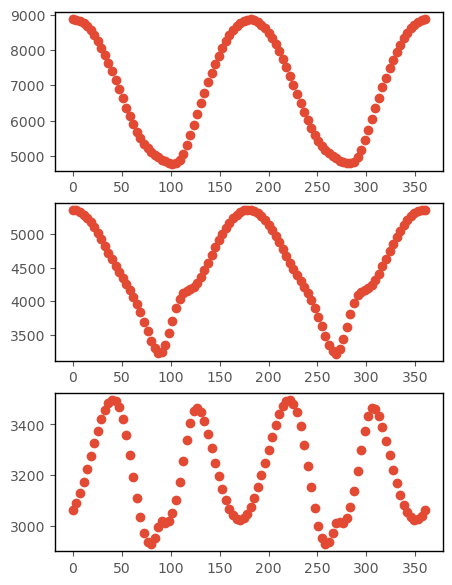

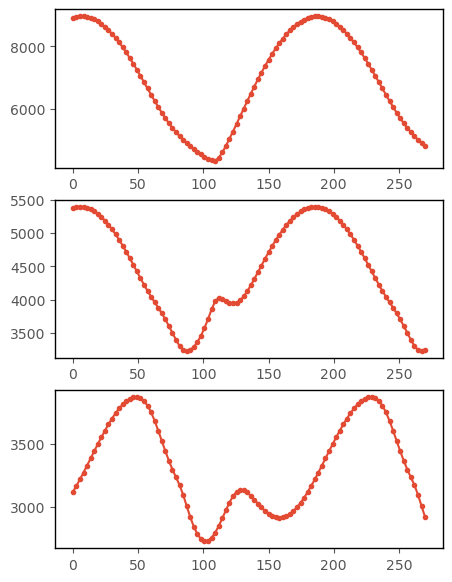

In [30]:
angles, vps, vs1s, vs2s = generate_sparse_test_data(mineral_type = anisotropy.TriclinicMaterial,
                                            Cijs = talc_stiffness,
                                            offset = 0,
                                            start_angle = 0.,
                                            end_angle = 360,
                                            hkl_norm = np.array([1,0,0]),
                                            unit_cell_params = [5.290, 9.173, 9.460, 90.46, 98.68, 90.09],
                                            rho = rho,
                                            n_data = 100,
                                            noise_mean = 0,
                                            noise_sigma = 0)



fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles, vps, 'o')
ax[1].plot(angles, vs1s, 'o')
ax[2].plot(angles, vs2s, 'o')
plt.show()

angles, vps, vs1s, vs2s = generate_sparse_test_data(mineral_type = anisotropy.TriclinicMaterial,
                                            Cijs = talc_stiffness,
                                            offset = np.random.rand() * 360,
                                            start_angle = 0.,
                                            end_angle = 270,
                                            hkl_norm = np.array([1,1,0]),
                                            unit_cell_params = [5.290, 9.173, 9.460, 90.46, 98.68, 90.09],
                                            rho = rho,
                                            n_data = 100,
                                            noise_mean = 0,
                                            noise_sigma = 0)



fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles, vps, '.-')
ax[1].plot(angles, vs1s, '.-')
ax[2].plot(angles, vs2s, '.-')
plt.show()

In [27]:
print(len(talc_stiffness))

21


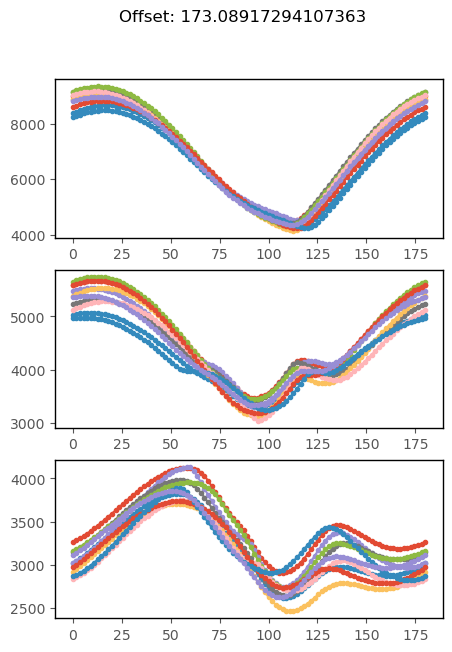

/Users/jordanando/opt/anaconda3/envs/minphys/lib/python3.11/site-packages/burnman/classes/anisotropy.py:279: RuntimeWarning: invalid value encountered in sqrt
  velocities = np.sqrt(eigenvalues / self.density)


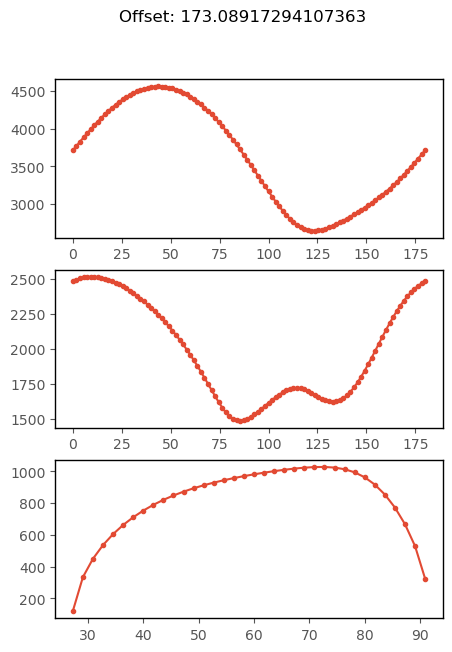

In [43]:
talc_stiffness = [219.83e9,  59.66e9,  -4.82e9,  -0.82e9, -33.87e9, -1.04e9,
                  216.38e9, -3.67e9,   1.79e9, -16.51e9,  -0.62e9,
                  48.89e9,    4.12e9, -15.52e9,  -3.59e9,
                  26.54e9,    -3.6e9,  -6.41e9,
                  22.85e9,   -1.67e9,
                  78.29e9] # Cij in Pa

talc_stiffness = np.array(talc_stiffness)
offset = np.random.rand() * 360
fig, ax = plt.subplots(3, 1, figsize = (5,7))

for i in range(10):
    angles, vps, vs1s, vs2s = generate_sparse_test_data(mineral_type = anisotropy.TriclinicMaterial,
                                                    Cijs = talc_stiffness * np.random.uniform(0.8, 1.2, talc_stiffness.shape),
                                                    offset = offset,
                                                    start_angle = 0.,
                                                    end_angle = 180,
                                                    hkl_norm = np.array([1,1,0]),
                                                    unit_cell_params = [5.290, 9.173, 9.460, 90.46, 98.68, 90.09],
                                                    rho = rho,
                                                    n_data = 100,
                                                    noise_mean = 0,
                                                    noise_sigma = 0)



    ax[0].plot(angles, vps, '.-')
    ax[1].plot(angles, vs1s, '.-')
    ax[2].plot(angles, vs2s, '.-')
    plt.suptitle("Offset: " + str(offset))
plt.show()

angles, vps, vs1s, vs2s = generate_sparse_test_data(mineral_type = anisotropy.TriclinicMaterial,
                                                    Cijs = talc_stiffness/np.abs(talc_stiffness) * 10e9,
                                                    offset = offset,
                                                    start_angle = 0.,
                                                    end_angle = 180,
                                                    hkl_norm = np.array([1,1,0]),
                                                    unit_cell_params = [5.290, 9.173, 9.460, 90.46, 98.68, 90.09],
                                                    rho = rho,
                                                    n_data = 100,
                                                    noise_mean = 0,
                                                    noise_sigma = 0)



fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles, vps, '.-')
ax[1].plot(angles, vs1s, '.-')
ax[2].plot(angles, vs2s, '.-')
plt.suptitle("Offset: " + str(offset))
plt.show()

### Test least squares fitting

In [115]:
import scipy.signal

max angle in data:  124.61538461538461
max angle in starting guess:  [  7.83783784 187.83783784]
Early offset guess:  63.222453222453225


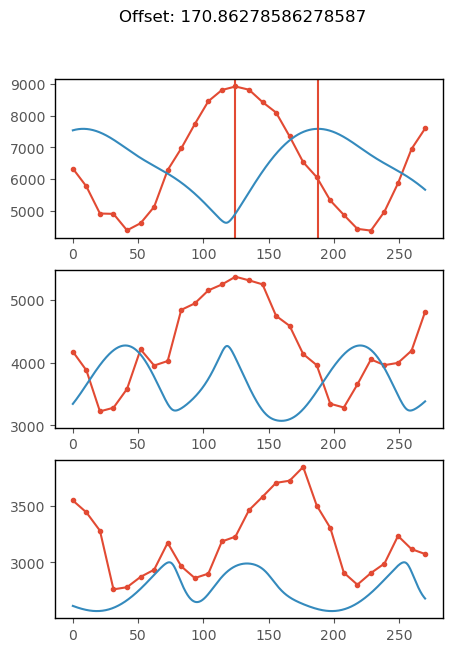

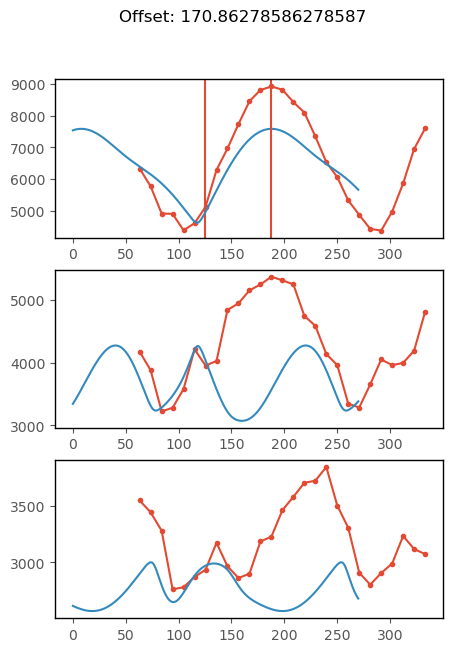

In [137]:

hkl_norm = np.array([1,1,0])
angles, vps, vs1s, vs2s = generate_sparse_test_data(mineral_type = anisotropy.TriclinicMaterial,
                                                    Cijs = talc_stiffness,
                                                    offset = 60,
                                                    start_angle = 0.,
                                                    end_angle = 270,
                                                    hkl_norm = hkl_norm,
                                                    unit_cell_params = [5.290, 9.173, 9.460, 90.46, 98.68, 90.09],
                                                    rho = rho,
                                                    n_data = 27,
                                                    noise_mean = 0,
                                                    noise_sigma = 1e2)


vs_stack = np.vstack([vps, vs1s, vs2s])

Cij_0 = talc_stiffness * np.random.uniform(0.1, 1.9, talc_stiffness.shape)
#Cij_0 = talc_stiffness/np.abs(talc_stiffness) * 11e9
unit_cell_params = [5.290, 9.173, 9.460, 90.46, 98.68, 90.09]

#Calculate offset
angles_o, vps_o, vs1s_o, vs2s_o = generate_sparse_test_data(mineral_type = anisotropy.TriclinicMaterial,
                                                    Cijs = Cij_0,
                                                    offset = 0,
                                                    start_angle = 0.,
                                                    end_angle = 270,
                                                    hkl_norm = hkl_norm,
                                                    unit_cell_params = unit_cell_params,
                                                    rho = rho,
                                                    n_data = 1000,
                                                    noise_mean = 0,
                                                    noise_sigma = 0)

max_angle_o = angles_o[scipy.signal.find_peaks(vps_o)[0]]
max_angle_data = angles[np.argmax(vps)]

#angle maximum in model = angle maximum in lab data - offset

offset_x = max_angle_data - max_angle_o
offset_x_idx = np.argmin(np.abs(offset_x))
offset_x = np.min(np.abs(offset_x))

print("max angle in data: ", max_angle_data)
print("max angle in starting guess: ", max_angle_o)
print("Early offset guess: ", offset_x)

fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles, vps, '.-')
ax[0].axvline(max_angle_data)
ax[1].plot(angles, vs1s, '.-')
ax[2].plot(angles, vs2s, '.-')
ax[0].plot(angles_o, vps_o, '-')
ax[0].axvline(max_angle_o[offset_x_idx])
ax[1].plot(angles_o, vs1s_o, '-')
ax[2].plot(angles_o, vs2s_o, '-')
plt.suptitle("Offset: " + str(offset))
plt.show()

fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles+offset_x, vps, '.-')
ax[0].axvline(max_angle_data)
ax[1].plot(angles+offset_x, vs1s, '.-')
ax[2].plot(angles+offset_x, vs2s, '.-')
ax[0].plot(angles_o, vps_o, '-')
ax[0].axvline(max_angle_o[offset_x_idx])
ax[1].plot(angles_o, vs1s_o, '-')
ax[2].plot(angles_o, vs2s_o, '-')
plt.suptitle("Offset: " + str(offset))
plt.show()



In [144]:
fit_result = fit_Cij_lsq(xs = angles,
                     ys = vs_stack,
                     theta_0 = np.append(Cij_0, offset_x),
                     mineral_type = anisotropy.TriclinicMaterial,
                     rho = rho,
                     hkl_norm=hkl_norm,
                     unit_cell_params=unit_cell_params
                     )

Cij_fit = fit_result[:-1]

/Users/jordanando/opt/anaconda3/envs/minphys/lib/python3.11/site-packages/burnman/classes/anisotropy.py:279: RuntimeWarning: invalid value encountered in sqrt
  velocities = np.sqrt(eigenvalues / self.density)


`xtol` termination condition is satisfied.
Function evaluations 44, initial cost 8.0806e+07, final cost 3.6208e+05, first-order optimality 4.78e+05.
[ 1.07171518e+11  7.89159972e+10  7.95270986e+09 -9.06624239e+09
 -7.76777284e+09 -4.54408488e+10  1.51523507e+11  3.70740268e+09
 -3.43644910e+10 -5.22034671e+09  3.76553290e+10  4.54233495e+10
 -2.96000577e+10  3.11291744e+09 -2.70771210e+10  7.26919256e+10
 -5.78850572e+09  2.20011069e+10  3.87140616e+10 -3.09434580e+10
  5.64279950e+10  2.14641261e+01]


<Figure size 1600x1000 with 0 Axes>

max angle in data:  124.61538461538461
max angle in starting guess:  [120.         299.81981982]
Early offset guess:  4.615384615384613


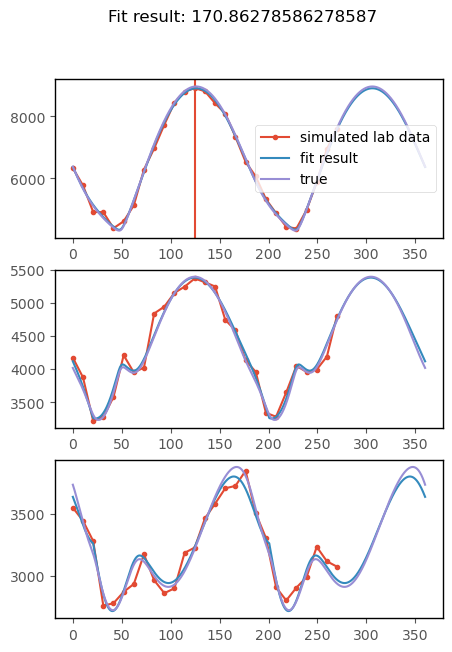

In [149]:
angles_fit, vps_fit, vs1s_fit, vs2s_fit = generate_sparse_test_data(mineral_type = anisotropy.TriclinicMaterial,
                                                    Cijs = Cij_fit,
                                                    offset = fit_result[-1],
                                                    start_angle = 0.,
                                                    end_angle = 360,
                                                    hkl_norm = hkl_norm,
                                                    unit_cell_params = unit_cell_params,
                                                    rho = rho,
                                                    n_data = 1000,
                                                    noise_mean = 0,
                                                    noise_sigma = 0)

angles_true, vps_true, vs1s_true, vs2s_true = generate_sparse_test_data(mineral_type = anisotropy.TriclinicMaterial,
                                                    Cijs = talc_stiffness,
                                                    offset = 60,
                                                    start_angle = 0.,
                                                    end_angle = 360,
                                                    hkl_norm = hkl_norm,
                                                    unit_cell_params = unit_cell_params,
                                                    rho = rho,
                                                    n_data = 1000,
                                                    noise_mean = 0,
                                                    noise_sigma = 0)


max_angle_o = angles_o[scipy.signal.find_peaks(vps_o)[0]]
max_angle_data = angles[np.argmax(vps)]

#angle maximum in model = angle maximum in lab data - offset

offset_x = max_angle_data - max_angle_o
offset_x_idx = np.argmin(np.abs(offset_x))
offset_x = np.min(np.abs(offset_x))

print("max angle in data: ", max_angle_data)
print("max angle in starting guess: ", max_angle_o)
print("Early offset guess: ", offset_x)

fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles, vps, '.-', label = "simulated lab data")
ax[0].axvline(max_angle_data)
ax[1].plot(angles, vs1s, '.-')
ax[2].plot(angles, vs2s, '.-')
ax[0].plot(angles_fit, vps_fit, '-', label = "fit result")
ax[1].plot(angles_fit, vs1s_fit, '-')
ax[2].plot(angles_fit, vs2s_fit, '-')
ax[0].plot(angles_true, vps_true, '-', label = "true")
ax[1].plot(angles_true, vs1s_true, '-')
ax[2].plot(angles_true, vs2s_true, '-')
plt.suptitle("Fit result: " + str(offset))
ax[0].legend()
plt.show()

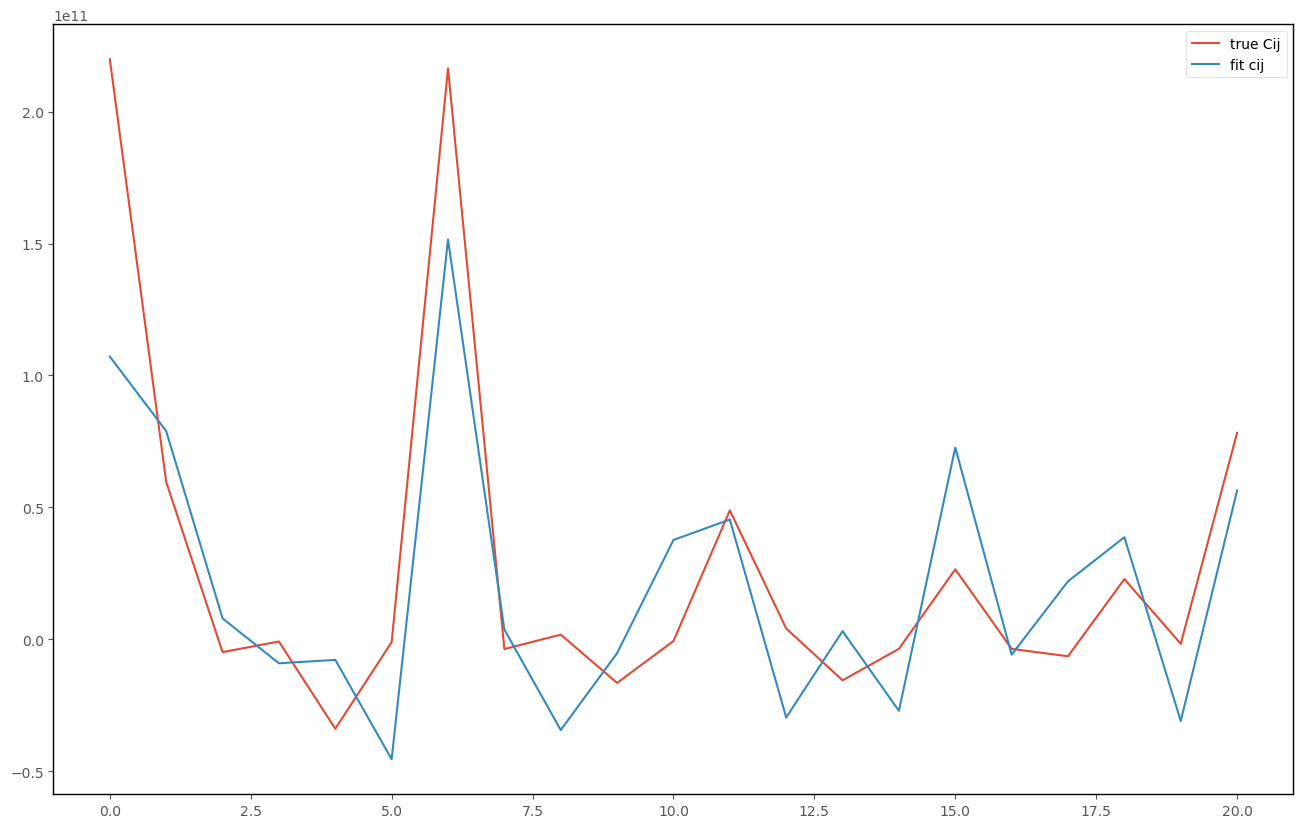

In [152]:
plt.figure()
plt.plot(talc_stiffness, label = "true Cij")
plt.plot(Cij_fit,  label = "fit cij")

plt.legend()
plt.show()

It works!

In [140]:
print(talc_stiffness)

[ 2.1983e+11  5.9660e+10 -4.8200e+09 -8.2000e+08 -3.3870e+10 -1.0400e+09
  2.1638e+11 -3.6700e+09  1.7900e+09 -1.6510e+10 -6.2000e+08  4.8890e+10
  4.1200e+09 -1.5520e+10 -3.5900e+09  2.6540e+10 -3.6000e+09 -6.4100e+09
  2.2850e+10 -1.6700e+09  7.8290e+10]
